In [1]:
import os
import itertools
import PIL
import copy
import datetime
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.utils as vutils
from torchvision import datasets
from torchvision.models import vgg19
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
from PIL import Image

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [10]:
# run params
SECTION = 'paint'
RUN_ID = '0001'
DATA_NAME = 'neural-style'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' # 'build' # 

In [62]:
data_folder = './data/neural-style'
image_save_folder = os.path.join(RUN_FOLDER, 'images')

os.makedirs(image_save_folder, exist_ok=True)

In [47]:
content_image_path = os.path.join(data_folder, 'tubingen.jpg')
style_image_name = 'starry-night.jpg'
style_image_path = os.path.join(data_folder, style_image_name)

content_image = Image.open(style_image_path)
style_image = Image.open(content_image_path)

width, height = content_image.size
img_height = 600
img_width = int(width * img_height / height)

print(img_width, img_height)

960 600


In [48]:
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    plt.show()

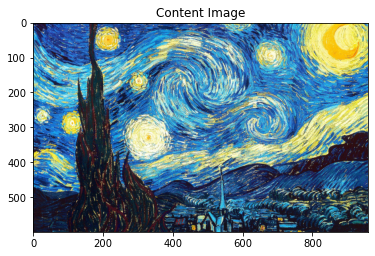

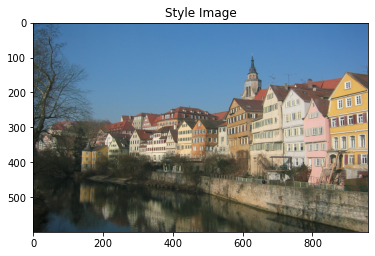

In [49]:
content_image = transform(content_image).unsqueeze(0).to(device)
style_image = transform(style_image).unsqueeze(0).to(device)


plt.figure()
imshow(content_image, 'Content Image')

plt.figure()
imshow(style_image, 'Style Image')

In [50]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [51]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    
    return G.div(a * b * c * d)

In [52]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [53]:
def total_variation_loss(x):
    a = torch.square(x[:, :, :img_height - 1, :img_width - 1] - x[:, :, 1:, :img_width - 1])
    b = torch.square(x[:, :, :img_height - 1, :img_width - 1] - x[:, :, :img_height - 1, 1:])
    return torch.sum(torch.pow(a + b, 1.25))

In [54]:
cnn = vgg19(pretrained=True).features.to(device).eval()
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [55]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [56]:
# 콘텐츠 손실에 사용할 층
content_layers = ['conv_4']
# 스타일 손실에 사용할 층
style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']

def get_style_model_and_losses(cnn, style_img, content_img):
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    
    content_losses = []
    style_losses = []
    
    model = nn.Sequential(normalization)
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        
        model.add_module(name, layer)
        
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
            
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
        
    model = model[:(i + 1)]
    
    return model, style_losses, content_losses

In [57]:
num_steps = 900
style_weight = 100000
content_weight = 1
total_variation_weight = 0.005

In [58]:
def run_style_transfer(cnn, content_img, style_img, input_img):
    model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)

    # 모델의 매개변수를 제외한 입력을 최적화해야 하므로
    # 이에 맞춰서 requires_grad 값을 갱신합니다.
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = optim.LBFGS([input_img])

    run = [0]
    while run[0] <= num_steps:
        def closure():
            # 업데이트 된 입력 이미지의 값을 수정
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            total_variation_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            total_variation_score = total_variation_loss(input_img)

            style_score *= style_weight
            content_score *= content_weight
            total_variation_score *= total_variation_weight

            loss = style_score + content_score + total_variation_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print(f"run {run[0]}:")
                print('Style Loss: {:4f} Content Loss: {:4f} Total Variation Loss: {:4f}'.format(
                    style_score.item(), content_score.item(), total_variation_score.item()))
                imshow(input_img)
                plt.imsave(os.path.join(image_save_folder, f'result_img_{style_image_name}_e_{run[0]}.png'), transforms.ToPILImage()(input_img.squeeze(0).detach().cpu()))

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

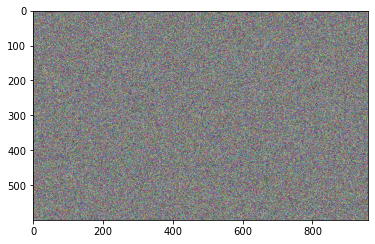

run 100:
Style Loss: 14.828526 Content Loss: 50.676708 Total Variation Loss: 32.113853


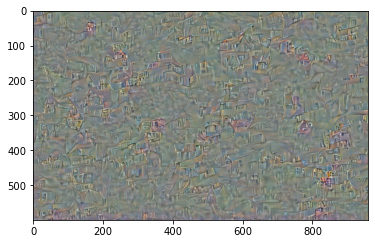

run 200:
Style Loss: 9.026226 Content Loss: 38.091988 Total Variation Loss: 17.365683


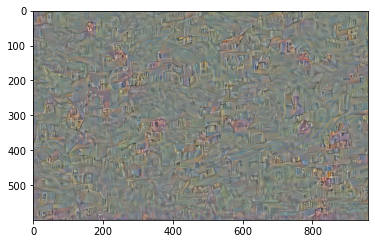

run 300:
Style Loss: 7.986496 Content Loss: 32.833755 Total Variation Loss: 15.730502


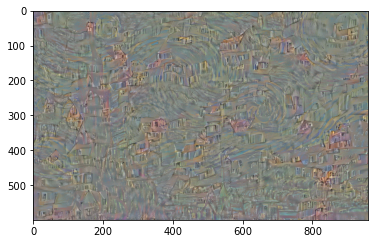

run 400:
Style Loss: 7.410965 Content Loss: 30.123837 Total Variation Loss: 15.308899


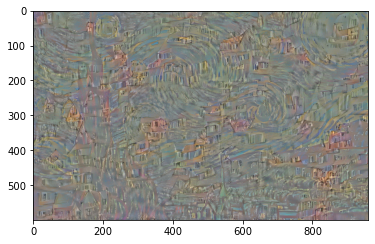

run 500:
Style Loss: 7.046178 Content Loss: 28.541931 Total Variation Loss: 15.121107


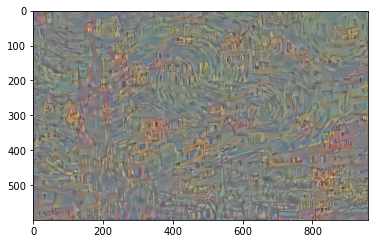

run 600:
Style Loss: 6.763138 Content Loss: 27.579124 Total Variation Loss: 15.023520


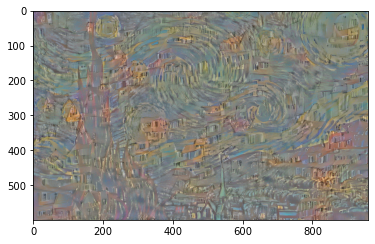

run 700:
Style Loss: 6.531303 Content Loss: 26.923864 Total Variation Loss: 14.964867


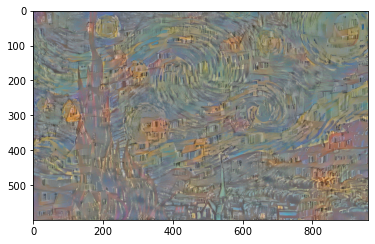

run 800:
Style Loss: 6.294218 Content Loss: 26.454800 Total Variation Loss: 14.928434


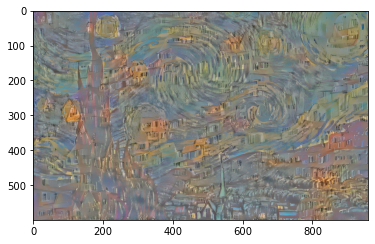

run 900:
Style Loss: 6.078472 Content Loss: 26.099951 Total Variation Loss: 14.892615


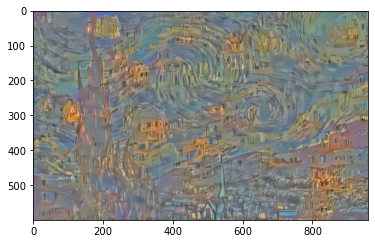

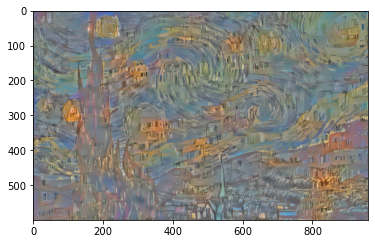

In [59]:
input_image = torch.empty_like(content_image).uniform_(0, 1).to(device)

imshow(input_image)
plt.imsave(os.path.join(image_save_folder, f'input_img.png'), transforms.ToPILImage()(input_image.squeeze(0).detach().cpu()))

output = run_style_transfer(cnn, content_image, style_image, input_image)

plt.figure()
imshow(output)

plt.ioff()
plt.show()